In [ ]:
import gym
from gym import spaces
from itertools import permutations 
import numpy as np
from scipy.spatial import distance_matrix
from matplotlib import pyplot as plt

# Create a gym environment

<p> First create a gym environment and than create an actor (robot) to play in the environment and learn the rules of game by it self, so that it can gain higher rewards.
<p> The game is defined below. The actor will start at the vertex '0' , and it will come back to vertex '0' after traversing the graph . When ever it makes a safe move from u to v (no cycle, no early stop), it will be given a reward (-dist(u,v)). Since the goal is to maximize the reward, the actor will try to find the shortest path. If it makes wrong move (repeated vertices, early stop), it will be heavily punished with -100000.
<p> This environment has a State-Action-Reward table, which records the reward of each action taken under different states.


In [ ]:
class TSPQEnv(gym.Env):
    def __init__(self, dist_matrix):
        # simple graph, N nodes
        self.N = len(dist_matrix)
        self.action_space = spaces.Discrete(self.N)

        # always start from node 0, obs = 1 + (n-1) + (n-1)*(n-2) + ... + (n-1)*...*1
        # e.g. when n = 7, observation_space = 1957

        self.observation_space = 1

        for length in range(1, self.N):
          cur_prod = 1
          for j in range(self.N-1, self.N-1-length, -1):
            cur_prod *= j
          self.observation_space += cur_prod

        # self.observation_space = 1957

        # encode states into integer
        self.obs_encode = dict()
        self.obs_encode['0'] = 0
        self.encode_obs = dict()
        self.encode_obs[0] = '0'

        # record the vertices contained under each state
        self.obs_set = dict()
        self.obs_set['0'] = set('0')

        obs_id = 1

        for l in range(1, self.N):
            permut = list(permutations([str(i) for i in range(1, self.N)], l))

            for i in range(len(permut)):
                string = '0' + "".join(permut[i])
                self.obs_encode[string] = obs_id
                self.encode_obs[obs_id] = string
                self.obs_set[string] = set(list(map(str, string)))
                obs_id += 1

        self.reward = np.zeros((self.observation_space, self.N))

        for i in range(self.observation_space):
            for j in range(self.N):
                obs = self.encode_obs[i]
                obs_set = self.obs_set[obs]

                if str(j) not in obs_set:
                    self.reward[i][j] = -dist_matrix[int(obs[-1])][j]
                elif str(j) != '0':
                    self.reward[i][j] = -1000000
                elif len(obs_set) != self.N:
                    self.reward[i][j] = -1000000
                else:
                    self.reward[i][j] = -dist_matrix[int(obs[-1])][j]

        self.reset()

    def step(self, action):
        if self.reward[self.obs_encode[self.S]][action] == -1000000:
            return self.S, -1000000, False, {}
        elif action == 0:
            reward = self.reward[self.obs_encode[self.S]][action]
            self.S = self.S + '0'
            return self.S, reward, True, {}
        else:
            reward = self.reward[self.obs_encode[self.S]][action]
            self.S = self.S + str(action)
            return self.S, reward, False, {}

    def reset(self):
        self.S = '0'
        return self.S

# Prepare the data

In [ ]:
!curl -LJO https://raw.githubusercontent.com/zhangky12/TSP_RL_Q/master/wi29.tsp.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   944  100   944    0     0   3791      0 --:--:-- --:--:-- --:--:--  3806


In [ ]:
f = open("wi29.tsp.txt", "r")
number = 10

In [ ]:
cities_loc = []
count = 0
for x in f:
  if count == number:
    break
  if x[0].isnumeric():
    count += 1
    location = x.split(' ')
    cities_loc.append([float(location[1]), float(location[2])])

In [ ]:
CG_matrix = distance_matrix(cities_loc, cities_loc)

In [ ]:
# initialize the environment 

env = TSPQEnv(CG_matrix)

In [ ]:
len(env.obs_encode)

986410

In [ ]:
#Model parameters
total_episodes = 10000
K = 10

#Learning rate
alpha = 0.1
#Discount rate
gamma = 0.95
#Exploration proportion
epsilon = 0.05

n_actions = env.action_space.n

In [ ]:
#Q-learning (off-policy TD learning)
#Epsilon greedy
def off_policy(Q, s, env, epsilon):
  if np.random.random() < epsilon:
    return env.action_space.sample()
  else:
    return np.argmax(Q[env.obs_encode[s], :])

In [ ]:
# Define the learning rules of actor. At each state, actor will check the reward table and choose the action that has the largest reward.

def train(env, policy, total_episodes = 500, run_test = False, test_freq = 10):
  #Set the agent at starting position
  s = env.reset()
  #Initialize Q values
  Q = np.zeros((len(env.obs_encode),n_actions))
  cumulative_reward = 0
  n_episodes = 0
  episode_rewards = []
  test_rewards = []
  #Here an episode only ends once we reach the goal location. 
  #So we're training for 500 successful episodes' worth of experience.
  while n_episodes < total_episodes:
    #Select action given current state
    action = policy(Q, s)
    prev_s = s
    #Step the environment forward
    s, reward, done, _ = env.step(action)
    #Now we have our current state, action, next state and reward
    #So we can take our updates
    if done:
      future_reward = reward
    else:
      future_reward = reward + gamma*np.max(Q[env.obs_encode[s], :])
    expected_future_reward = Q[env.obs_encode[prev_s], action]
    Q[env.obs_encode[prev_s], action] += alpha*(future_reward-expected_future_reward)
    cumulative_reward += reward
    #Reset the agent if we're done. Track rewards
    if done:
      if run_test and n_episodes%test_freq == 0:
        test_r = test(env, on_policy, Q)
        test_rewards.append([n_episodes, test_r])
      s = env.reset()
      episode_rewards.append(cumulative_reward)
      n_episodes += 1
      cumulative_reward = 0

  return episode_rewards, Q

In [ ]:
qlearning_rewards = np.zeros((K, total_episodes))
qpolicy = lambda q,s: off_policy(q, s, env, epsilon)

In [ ]:
for idx in range(K):
  #Train with Q-learning
  rewards, Q_q = train(env, qpolicy, total_episodes)
  #rewards, Q_q = train(env, on_policy, total_episodes)
  qlearning_rewards[idx,:] = rewards

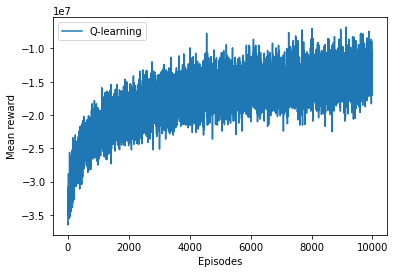

In [ ]:
plt.plot(np.mean(qlearning_rewards[:,10:], 0).T)
plt.legend(['Q-learning'])
plt.xlabel('Episodes')
plt.ylabel('Mean reward');
#plt.ylim([-200,0]);

In [ ]:
path = '0'
dist = 0
for i in range(len(CG_matrix)):
  next_step = str(np.argmax(Q_q[env.obs_encode[path]]))
  path += next_step

path = [int(i) for i in path] 
path

[0, 1, 5, 4, 3, 7, 2, 6, 8, 9, 0]

In [ ]:
# Total length
q_length = 0
for i in range(len(path)-1):
  q_length += CG_matrix[path[i]][path[i+1]]

q_length 

14006.338097664993

In [ ]:
arranged_cities = []
for i in list(map(int, path[:-1])):
  arranged_cities.append(cities_loc[i])
arranged_cities.append(cities_loc[0])

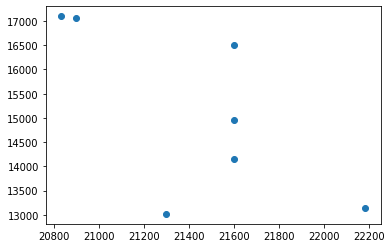

In [ ]:
plt.scatter([i[0] for i in cities_loc], [i[1] for i in cities_loc])

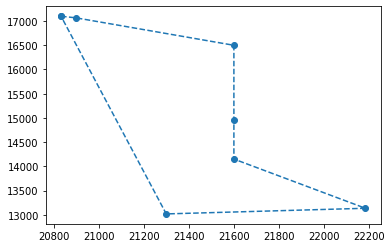

In [ ]:
plt.plot([i[0] for i in arranged_cities], [i[1] for i in arranged_cities], 
         'o',
         linestyle='dashed')